In [1]:
# streamlit directory
# cd "C:/Users/tsaie/OneDrive/Desktop/000 Resumes & Projects/# Projects/FARS/python app - streamlit"
# streamlit run app.py

from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re

from datetime import datetime
from time import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import spacy

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# CHANGE category
category = 'Electronics'

# CHANGE general_file_path
general_file_path = "C:/Users/tsaie/OneDrive/Desktop/000 Resumes & Projects/# Projects/FARS/"

In [3]:
# Load the rf_model, gold_bigram_df, and fake_bigram_df
ML_model_file_path = general_file_path + "Ester Tsai (Bigram and ML)/ML Models/"

ML_model_file_name = f'2022_05_11 rf_model {(category)}.joblib'
rf_model = load(ML_model_file_path + ML_model_file_name) 

bigram_file_path = general_file_path + "Ester Tsai (Bigram and ML)/Bigrams/"

gold_bigram_file_name = f'{(category)} gold_bigrams.csv'
gold_bigram_df = pd.read_csv(bigram_file_path + gold_bigram_file_name, index_col=0)

fake_bigram_file_name = f'{(category)} fake_bigrams.csv'
fake_bigram_df = pd.read_csv(bigram_file_path + fake_bigram_file_name, index_col=0)


def data_cleaning(df):
    
    start_1 = time()
    
    # Removing emtpy cells
    df.dropna(inplace=True)
    df['review_cleaned'] = df['review_body'].copy()
    
    # Removing Unicode Chars (URL)
    df['review_cleaned'] = df['review_cleaned'].apply(
        lambda rev: re.sub(r"(\w+:\/\/\S+)|^rt|http.+?", "", rev))
        
    # Replace HTML keywords with blank space ("&quot;", "br", "&#34")
    remove_dict = {"<br /><br />": " ", "<br />": " ", "br ": "", "&quot;": " ", "&#34": " ",
                   "<BR>": " ", "_": ""}
    for key, val in remove_dict.items():
        df['review_cleaned'] = df['review_cleaned'].apply(
            lambda x: x.replace(key, val))
        
    end_1 = time()
        
    print(f"\n######## [{end_1 - start_1:0.2f} secs] Remove URL and HTML Keywords Complete ########")
    
    start_2 = time()
    
    # Remove Punctuations and numbers
    tokenizer = RegexpTokenizer(r'\w+')
    df['review_cleaned'] = df['review_cleaned'].apply(
        lambda x: ' '.join([word for word in tokenizer.tokenize(x)]))
    
    remove_dict = {"0": "", "1": "", "2": "", "3": "", "4": "", "5": "", "6": "", "7": "", "8": "", "9": "",
                   "(": "", ")":""}
    for key, val in remove_dict.items():
        df['review_cleaned'] = df['review_cleaned'].apply(
            lambda x: x.replace(key, val))
    
    end_2 = time()
    
    print(f"\n######## [{end_2 - start_2:0.2f} secs] Remove Punctuation and Numbers Complete ########")
    
    start_3 = time()
    
    # Lowercase Words
    df['review_cleaned'] = df['review_cleaned'].str.lower()
    
    end_3 = time()
    
    print(f"\n######## [{end_3 - start_3:0.2f} secs] Lowercase Complete ########")
    
    start_4 = time()

    # Remove Stop Words.
    stop = stopwords.words('english')
      
    df['review_cleaned'] = df['review_cleaned'].apply(
        lambda x: ' '.join([word for word in x.split() if word.strip() not in stop]))
    
    end_4 = time()
    
    print(f"\n######## [{end_4 - start_4:0.2f} secs] Remove Stop Words Complete ########")
    
    start_5 = time()
    
    # Lemmatization using .lemma_
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    df['review_cleaned'] = df['review_cleaned'].apply(
        lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
    
    end_5 = time()
    
    print(f"\n######## [{end_5 - start_5:0.2f} secs] Lemmatization Complete ########")
    
    return df



from collections import Counter
from nltk import ngrams
from itertools import chain

def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

def add_bigram_column(df):
    copy = df.copy()
    copy['bigrams'] = copy['review_cleaned'].map(lambda x: find_ngrams(x.split(), 2))
    return copy




def get_bigram_count(bigrams, bigram_dict):
    if len(bigrams) == 0:
        return 0
    
    count = 0
    for bigram in bigrams:
        if bigram in bigram_dict.keys():
            count += 1
    return count

def get_count_percent(bigrams, bigram_dict):
    if len(bigrams) == 0:
        return 0
    
    count = get_bigram_count(bigrams, bigram_dict)
    return count / len(bigrams)

def get_averge_top_score(bigrams, bigram_dict, topN=5):
    if len(bigrams) == 0:
        return 0
    
    scores = np.array([])
    for bigram in bigrams:
        if bigram in bigram_dict.keys():
            scores = np.append(scores, bigram_dict[bigram])
    
    if len(bigrams) <= topN:
        return scores.mean()
    
    sort_descending = -np.sort(-scores)[:topN]
    avg_top_score = sort_descending.mean()
    return avg_top_score

def get_normalized_score(bigrams, bigram_dict):
    if len(bigrams) == 0:
        return 0
    
    score = 0
    for bigram in bigrams:
        if bigram in bigram_dict.keys():
            score += bigram_dict[bigram]
    return score / len(bigrams)

def get_unique_percent(bigrams, bigram_dict, the_other_bigram_dict, unique_threshold=0):
    # Count the number of bigrams in a review that appear in bigram_dict but not the_other_bigram_dict. 
    # Can adjust unique_threshold so you can count also the bigrams that appear in ...
    # ...the_other_bigram_dict fewer than unique_threshold times
    
    if len(bigrams) == 0:
        return 0
    
    count = get_bigram_count(bigrams, bigram_dict)
    for bigram in bigrams:
        if bigram in the_other_bigram_dict.keys():
            if the_other_bigram_dict[bigram] > unique_threshold:
                count -= 1
    return count / len(bigrams)

def has_fake_keywords(bigrams):
    fake_keywords = ['honest', 'unbiased', 'unbias', 'biased', 'bias', 'neutral', 'impartial', 'truthful', 
                     'discount', 'free', 'promotion', 'promote', 'complimentary', 'test', 'influence', 'influencer',
                     'independent']
    fake_tuples = [('receive', 'product'), ('product', 'receive'), ('provide', 'review'), 
                   ('product', 'exchange'), ('exchange', 'review'), ('review', 'opinion'),
                   ('sample', 'provide'), ('provide', 'sample'), ('sample', 'review'), ('review', 'sample'), 
                   ('sample', 'product'), ('supply', 'sample'), ('receive', 'sample'), ('sample', 'receive')] 
    
    for kw in fake_tuples:
        if kw in bigrams:
            return True
            
    for bigram in bigrams:
        for kw in fake_keywords:
            if kw in bigram:
                return True
    
    return False






def add_gold_fake_features(df):
    
    for gold_or_fake in ['gold', 'fake']:

        exec(f"df['{gold_or_fake}%'] = df['bigrams'].apply(\
            lambda x: get_count_percent(x, {gold_or_fake}_bigram_dict_filtered))")
        
        exec(f"df['{gold_or_fake}_unique%'] = df['bigrams'].apply(\
            lambda x: get_unique_percent(x, {gold_or_fake}_bigram_dict, {gold_or_fake}_bigram_dict, 3))")

        exec(f"df['{gold_or_fake}_score'] = df['bigrams'].apply(\
            lambda x: get_normalized_score(x, {gold_or_fake}_bigram_dict))")
        
        exec(f"df['{gold_or_fake}_top_score'] = df['bigrams'].apply(\
            lambda x: get_averge_top_score(x, {gold_or_fake}_bigram_dict, 1))")
        
        exec(f"df['{gold_or_fake}_top_avg_score'] = df['bigrams'].apply(\
            lambda x: get_averge_top_score(x, {gold_or_fake}_bigram_dict, 5))")

    df['has_fake_keywords'] = df['bigrams'].apply(lambda x: has_fake_keywords(x))
    
    return df





def gold_bigram_df_to_vars(gold_bigram_df):
    global gold_bigrams, gold_bigram_dict, gold_bigram_dict_filtered
    gold_bigrams = gold_bigram_df['bigram'].to_list()
    str_to_tuple = lambda x: (x.split("'")[1], x.split("'")[3])
    gold_bigrams = list(map(str_to_tuple, gold_bigrams))
    gold_bigram_dict = {gold_bigrams[i]: gold_bigram_df['count'].iloc[i] for i in range(len(gold_bigrams))}
    gold_bigram_dict_filtered = dict((k, v) for k, v in gold_bigram_dict.items() if v >= 2)
    
def fake_bigram_df_to_vars(fake_bigram_df):
    global fake_bigrams, fake_bigram_dict, fake_bigram_dict_filtered
    fake_bigrams = fake_bigram_df['bigram'].to_list()
    str_to_tuple = lambda x: (x.split("'")[1], x.split("'")[3])
    fake_bigrams = list(map(str_to_tuple, fake_bigrams))
    fake_bigram_dict = {fake_bigrams[i]: fake_bigram_df['count'].iloc[i] for i in range(len(fake_bigrams))}
    fake_bigram_dict_filtered = dict((k, v) for k, v in fake_bigram_dict.items() if v >= 2)
    
    
    
    
def clean_review_and_add_features(review, gold_bigram_df, fake_bigram_df):
    
    # Create dataframe for the input review
    df = pd.DataFrame(data={'review_body': review}, index=[0])
    
    # Create helper variables
#     gold_bigram_df_to_vars(gold_bigram_df)
#     fake_bigram_df_to_vars(fake_bigram_df)
    
    # Clean the user input
    df = data_cleaning(df) 
    
    # Add the column 'bigrams'
    df['bigrams'] = df['review_cleaned'].map(lambda x: find_ngrams(x.split(), 2))
    df['bigram_count'] = df['bigrams'].apply(lambda x: len(x))
    
    # Add features to score the user input
    df = add_gold_fake_features(df)

    return df

In [4]:
# Create helper variables (TAKES ~20 SECONDS TO LOAD)
gold_bigram_df_to_vars(gold_bigram_df)
fake_bigram_df_to_vars(fake_bigram_df)

## Try changing the review and see what the RandomForest model predicts!

In [26]:
review = "Turbo charger, small and portable and fits perfectly in your pocket! A nice boost over regular chargers. I received this in exchange for an unbiased review."

# Clean the user input and create a dataframe for it
user_input_processed_df = clean_review_and_add_features(review, gold_bigram_df, fake_bigram_df)

def prepare_df_for_prediction(processed_df):
    features = ['bigram_count', 
            'fake%', 'fake_unique%', 'fake_score', 'fake_top_avg_score', 'fake_top_score',
            'gold%', 'gold_unique%', 'gold_score', 'gold_top_avg_score', 'gold_top_score',
            'has_fake_keywords']
    return processed_df[features]

df_for_prediction = prepare_df_for_prediction(user_input_processed_df)

prediction, probabilities = rf_model.predict(df_for_prediction)[0], rf_model.predict_proba(df_for_prediction)[0]
# prediction: 0 = unverified, 1 = verified
# probabilities[0] = prob of unverified  |  probabilities[1] = prob of verified


######## [0.00 secs] Remove URL and HTML Keywords Complete ########

######## [0.00 secs] Remove Punctuation and Numbers Complete ########

######## [0.00 secs] Lowercase Complete ########

######## [0.01 secs] Remove Stop Words Complete ########

######## [0.53 secs] Lemmatization Complete ########


# (The cell below is new/ updated)

PREDICTION: UNVERIFIED (58.5%) | VERIFIED (41.5%)


,review_body,review_cleaned,bigrams
0,"Turbo charger, small and portable and fits perfectly in your pocket! A nice boost over regular chargers. I received this in exchange for an unbiased review.",turbo charger small portable fit perfectly pocket nice boost regular charger receive exchange unbiased review,"[(turbo, charger), (charger, small), (small, portable), (portable, fit), (fit, perfectly), (perfectly, pocket), (pocket, nice), (nice, boost), (boost, regular), (regular, charger), (charger, receive), (receive, exchange), (exchange, unbiased), (unbiased, review)]"


,Overall Proportion,Unique Proprotion,Overall Score,Top 5 Avg Score,Top Score
Gold,0.428571,0.428571,31.642857,87.6,364.0
Fake,0.785714,0.000000,106.214286,287.0,576.0


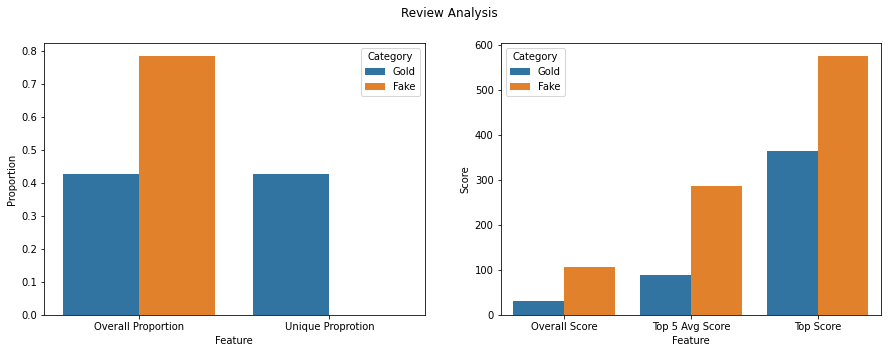

In [27]:
def interpret_prediction(review, pred, proba, print_review=True):
    prob_unverified, prob_verified = round(proba[0] * 100, 1), round(proba[1] * 100, 1)
    
    if print_review:
        print(f'\nREVIEW: "{review}" \n')
        
    if pred == 1:
        print(f'PREDICTION: VERIFIED ({prob_verified}%) | UNVERIFIED ({prob_unverified}%)')
    if pred == 0:
        print(f'PREDICTION: UNVERIFIED ({prob_unverified}%) | VERIFIED ({prob_verified}%)')

def plot_scores(review, user_input_processed_df, prediction, probabilities):
    review_df = user_input_processed_df[['review_body', 'review_cleaned', 'bigrams']]
    
    # DISPLAY IN STREAMLIT!
    interpret_prediction(review, prediction, probabilities, print_review=False)
    # DISPLAY IN STREAMLIT!
    display(review_df)
    
    R = user_input_processed_df.loc[0]
    
    df_for_display = pd.DataFrame([{'Overall Proportion': R['gold%'], 'Unique Proprotion': R['gold_unique%'], 
                                    'Overall Score': R['gold_score'], 'Top 5 Avg Score': R['gold_top_avg_score'], 
                                    'Top Score': R['gold_top_score']},
                                   {'Overall Proportion': R['fake%'], 'Unique Proprotion': R['fake_unique%'], 
                                    'Overall Score': R['fake_score'], 'Top 5 Avg Score': R['fake_top_avg_score'], 
                                    'Top Score': R['fake_top_score']}],
                                     index=['Gold', 'Fake'])
    # DISPLAY IN STREAMLIT!
    display(df_for_display)
    
    compare_percentages_for_plot = pd.DataFrame({'Category':['Gold']*2+['Fake']*2,
                                   'Feature':['Overall Proportion', 'Unique Proprotion']*2,
                                   'Proportion':[R['gold%'], R['gold_unique%'], R['fake%'], R['fake_unique%']]})

    compare_scores_for_plot = pd.DataFrame({'Category':['Gold']*3+['Fake']*3,
                              'Feature':['Overall Score', 'Top 5 Avg Score', 'Top Score']*2,
                              'Score': [R['gold_score'], R['gold_top_avg_score'], R['gold_top_score'], 
                                        R['fake_score'], R['fake_top_avg_score'], R['fake_top_score']]})
    
    # DISPLAY IN STREAMLIT!
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    fig.suptitle(f'Review Analysis')
    ax = axes[0]
    sns.barplot(ax=ax, x='Feature', y='Proportion', hue='Category', data=compare_percentages_for_plot) 
    ax = axes[1]
    sns.barplot(x='Feature', y='Score', hue='Category', data=compare_scores_for_plot) 
    

# PLOT THE REVIEW ANALYSIS + COMPARISON
plot_scores(review, user_input_processed_df, prediction, probabilities)

# What the Features Mean (PLEASE PUT THIS ON STREAMLIT)

To reduce word space, let "gold" represent "verified," and let "fake" represent "unverified."
NOTE: An "unverified" review isn't necessarily fake. A review is defined as "unverified" if the user did not buy the product from Amazon.

### Setup
- <code>gold_bigram_dict</code> contains all the bigrams that appeared in verified reviews and their # of occurrences 
- <code>fake_bigram_dict</code> contains all the bigrams that appeared in unverified reviews and their # of occurrences 

### Features
<code>bigram_count</code> = # of bigrams in the review

<code>gold%</code> ("Overall Proportion") = # bigrams in the review that appear in <code>gold_bigram_dict</code> at least 2 times / bigram_count

<code>gold_unique%</code> ("Unique Proprotion") = (# of bigrams that exist in <code>gold_bigram_dict</code> - # of bigrams that appear in <code>fake_bigram_dict</code> at least 3 times) / bigram_count

<code>gold_score</code> ("Overall Score") = sum of all the bigrams' # of occurrences in verified reviews / bigram_count

<code>gold_top_avg_score</code> ("Top 5 Avg Score") = sum of the top 5 bigrams' # of occurrences in verified reviews / 5

<code>gold_top_score</code> ("Top Score") = highest # of occurrences in verified reviews

Similar logic for the features <code>fake%</code>, <code>fake_unique%</code>, <code>fake_score</code>, <code>fake_top_avg_score</code>, and <code>fake_top_score</code>.

# Gold & Fake Reviews from the Datasets (IGNORE FOR NOW)

## Electronics

### Gold:


### Fake:

Turbo charger, small and portable and fits perfectly in your pocket! A nice boost over regular chargers. I received this in exchange for an unbiased review.

This is a thick high quality cable, my picture is crystal clear and this is just the right length for my needs, I received this in exchange for my honest review.

Small, lightweight, fits on my desk. Does not come with batteries, I already had some. I received a discount for this review.

## Beauty

### Gold:


### Fake:



## Toys

### Gold:


### Fake:



## Office Products

### Gold:


### Fake:


## Apparel

### Gold:


### Fake:

